In [2]:
import os
from collections import OrderedDict
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import glob

from scipy.stats import ttest_ind as tt
from scipy.stats import wilcoxon, spearmanr, permutation_test
import scanpy as sc
import anndata as ad

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

sc.set_figure_params(figsize=(5,5), frameon=False)

In [3]:
run_name = "Graph-Perciever_September-17"
fold_idx = 2
features_path = os.path.join("/SeaExp/Rushin/TNTA/logs/", run_name+"_fold_{}".format(fold_idx))
pcga_metadata_path = os.path.join("/SeaExp/Rushin/datasets/", "PCGA", "assay_file.txt")

In [4]:
all_adata = sc.read_h5ad(os.path.join(features_path, 'all_samples_adata.h5ad'))
pcga_adata = all_adata.copy()
pcga_adata

AnnData object with n_obs × n_vars = 2529 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2'
    uns: 'bulk_labels_colors', 'bulk_labels_sizes', 'bulk_merge_labels_colors', 'cohort_names_colors', 'dendrogram_bulk_labels', 'dendrogram_labels', 'dendrogram_leiden', 'labels_colors', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'pca', 'rank_features_ttest_bulk_labels', 'rank_features_wilcoxon_bulk_labels', 'rank_features_wilcoxon_labels', 'tsne', 'umap', 'umap_density_labels_params'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

In [5]:
pcga_metadata = pd.read_csv(pcga_metadata_path, header = 0, sep='\t')

pcga_metadata = pcga_metadata[['PCGAID', 'Molecular_Subtype', 'Molecular_Subtype_BrushPrediction', 'Progression_Status', 'TCGA_Subtype']]
pcga_metadata.index = pcga_metadata['PCGAID']
del pcga_metadata['PCGAID']
pcga_metadata.head()

,Molecular_Subtype,Molecular_Subtype_BrushPrediction,Progression_Status,TCGA_Subtype
PCGAID,,,,
PCGA-01-0001-029-20126-01119BX,Secretory,NotProliferative,UNK,Secretory
PCGA-01-0001-037-19118-00482BX,Proliferative,Proliferative,Regressive,Basal
PCGA-01-0001-037-19300-00589BX,Secretory,NotProliferative,Normal/Stable,Secretory
PCGA-01-0001-037-19762-00898BX,Secretory,NotProliferative,Normal/Stable,Primitive
PCGA-01-0001-037-20126-01120BX,Proliferative,Proliferative,Normal/Stable,Basal


In [6]:
q = pcga_adata[pcga_adata.obs['cohort_names'] == 'Roswell']
pcga_sample_names = q.obs_names
for col in pcga_metadata.columns:
    pcga_adata.obs[col] = pcga_metadata.loc[pcga_sample_names, col]

pcga_adata.obs['pc1'] = pcga_adata.obsm['X_pca'][:, 0]
pcga_adata.obs['pc2'] = pcga_adata.obsm['X_pca'][:, 1]

pcga_adata

AnnData object with n_obs × n_vars = 2529 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2', 'Molecular_Subtype', 'Molecular_Subtype_BrushPrediction', 'Progression_Status', 'TCGA_Subtype'
    uns: 'bulk_labels_colors', 'bulk_labels_sizes', 'bulk_merge_labels_colors', 'cohort_names_colors', 'dendrogram_bulk_labels', 'dendrogram_labels', 'dendrogram_leiden', 'labels_colors', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'pca', 'rank_features_ttest_bulk_labels', 'rank_features_wilcoxon_bulk_labels', 'rank_features_wilcoxon_labels', 'tsne', 'umap', 'umap_density_labels_params'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

In [7]:
sc.pl.umap(pcga_adata, color=['Molecular_Subtype', 'Molecular_Subtype_BrushPrediction', 'Progression_Status', 'TCGA_Subtype'], show=False, na_in_legend=False, legend_fontsize='large', size=30, frameon=True, wspace=0.8, save='pcga_metadata.pdf')
sc.pl.umap(pcga_adata, color=['labels'], groups=['dysplasia', 'hyperplasia', 'metaplasia', 'pml_normal'], show=False, na_in_legend=False, legend_fontsize='large', size=30, frameon=True, wspace=0.8, save='pcga_labels.pdf')

<AxesSubplot: title={'center': 'labels'}, xlabel='UMAP1', ylabel='UMAP2'>

<AxesSubplot: title={'center': 'Molecular_Subtype_BrushPrediction'}, xlabel='PC1', ylabel='PC2'>

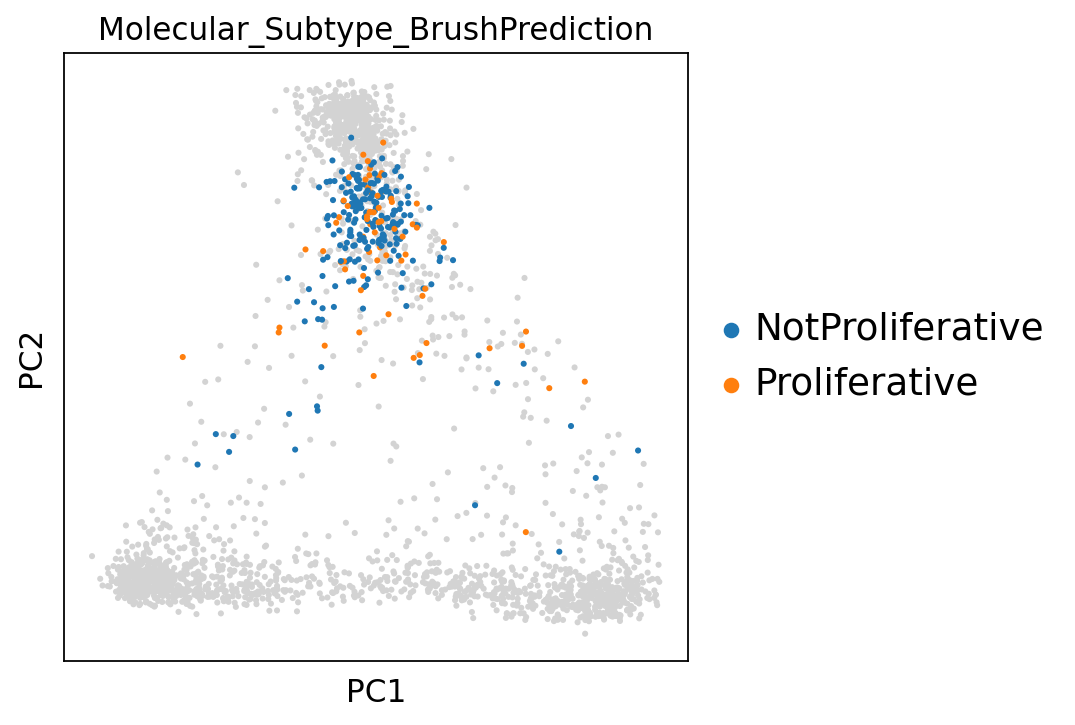

In [8]:
sc.pl.pca(pcga_adata, color=['Molecular_Subtype_BrushPrediction'], show=False, na_in_legend=False, legend_fontsize='large', size=30, frameon=True, wspace=0.8)

In [9]:
sc.pl.pca(pcga_adata, color=['Molecular_Subtype', 'Molecular_Subtype_BrushPrediction', 'Progression_Status', 'TCGA_Subtype'], show=False, na_in_legend=False, legend_fontsize='large', size=30, frameon=True, wspace=0.8, save='pcga_metadata.pdf')
sc.pl.pca(pcga_adata, color=['labels'], groups=['dysplasia', 'hyperplasia', 'metaplasia', 'pml_normal'], show=False, na_in_legend=False, legend_fontsize='large', size=30, frameon=True, wspace=0.8, save='pcga_labels.pdf')

<AxesSubplot: title={'center': 'labels'}, xlabel='PC1', ylabel='PC2'>

In [10]:
not_proliferative = pcga_adata[pcga_adata.obs.Molecular_Subtype_BrushPrediction == 'NotProliferative']
proliferative = pcga_adata[pcga_adata.obs.Molecular_Subtype_BrushPrediction == 'Proliferative']

statistic, p_value = tt(proliferative.obs.pc1, not_proliferative.obs.pc1)
print("PC1 T-Test: ", statistic, p_value)

statistic, p_value = tt(proliferative.obs.pc2, not_proliferative.obs.pc2)
print("PC2 T-Test: ", statistic, p_value)

PC1 T-Test:  1.8232484348699023 0.06934348160626687
PC2 T-Test:  -1.4770243783366432 0.14080509124900648


In [22]:
cptac_adata = all_adata[all_adata.obs.cohort_names == 'CPTAC']
cptac_luad = cptac_adata[cptac_adata.obs.labels == 'luad']
cptac_lusc = cptac_adata[cptac_adata.obs.labels == 'lusc']

print(cptac_luad)
print(cptac_lusc)

pcga_adata = all_adata[all_adata.obs.cohort_names == 'Roswell']

pml_v_lusc_pc1, pml_v_lusc_pc1_p_value = tt(pcga_adata.obs.pc1, cptac_lusc.obs.pc1)
pml_v_luad_pc1, pml_v_luad_pc1_p_value = tt(pcga_adata.obs.pc1, cptac_luad.obs.pc1)

print("PML vs LUSC (PC1):",  pml_v_lusc_pc1, pml_v_lusc_pc1_p_value)
print("PML vs LUAD (PC1):",  pml_v_luad_pc1, pml_v_luad_pc1_p_value)

pml_v_lusc_pc2, pml_v_lusc_pc2_p_value = tt(pcga_adata.obs.pc2, cptac_lusc.obs.pc2)
pml_v_luad_pc2, pml_v_luad_pc2_p_value = tt(pcga_adata.obs.pc2, cptac_luad.obs.pc2)
print("PML vs LUSC (PC2):",  pml_v_lusc_pc2, pml_v_lusc_pc2_p_value)
print("PML vs LUAD (PC2):",  pml_v_luad_pc2, pml_v_luad_pc2_p_value)

View of AnnData object with n_obs × n_vars = 667 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2'
    uns: 'bulk_labels_colors', 'bulk_labels_sizes', 'bulk_merge_labels_colors', 'cohort_names_colors', 'dendrogram_bulk_labels', 'dendrogram_labels', 'dendrogram_leiden', 'labels_colors', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'pca', 'rank_features_ttest_bulk_labels', 'rank_features_wilcoxon_bulk_labels', 'rank_features_wilcoxon_labels', 'tsne', 'umap', 'umap_density_labels_params'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 685 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2'
    uns: 'bulk_labels_colors', 'bulk_labels_sizes', 'bulk_merge_labels_colors', 'cohort_names_colors', 'den